# 202055502 강동권 데이터마이닝 과제 (Dong Gwon Kang Data Mining PA)

## 한국환경공단_도로 재비산먼지 측정 정보 (Korean Road Dust Measurements)

### Source of data : https://www.data.go.kr/data/15021888/fileData.do
### GITHUB LINK : https://github.com/TonnyKang/PNU_2024_dataMining_Final

### 1. 데이터 열어서 확인하기, Opening up the data

In [23]:
import pandas as pd

# Specify the file name
file_name = "한국환경공단_도로 재비산먼지 측정 정보_20241130.csv"

try:
    data = pd.read_csv(file_name, encoding="euc-kr")  # encoding setting for Korean 
    print(data.head())
except UnicodeDecodeError as e:
    print(f"Error reading the file: {e}")
    print("Trying with a different encoding...")
    data = pd.read_csv(file_name, encoding="cp949")
    print(data.head())



         측정일자   측정시간  지역 지역명    도로명                    시작점  \
0  2024-11-01  16:04  인천  서구    에코로  인천광역시 서구 경서동 519-44 답   
1  2024-11-01  15:55  인천  서구   청라대로  인천광역시 서구 원창동 403-43 전   
2  2024-11-01  15:40  인천  서구    경제로      인천광역시 서구 연희동 821도   
3  2024-11-01  15:29  인천  서구  청라한울로    인천광역시 서구 경서동 855-5도   
4  2024-11-01  15:20  인천  서구  크리스탈로    인천광역시 서구 경서동 970-6도   

                      종점  기온  습도  재비산먼지 평균농도  오염범례  
0  인천광역시 서구 경서동 542-37 답  18  64          78    좋음  
1           인천광역시 서구 경서동  19  63          83    좋음  
2   인천광역시 서구 경서동 584-1 잡  19  63          15  매우좋음  
3    인천광역시 서구 경서동 837-8도  19  63          24  매우좋음  
4   인천광역시 서구 경서동 836-99도  19  64          37  매우좋음  


데이터를 직접 열어서 확인해보니

"측정일자, 측정시간, 지역, 지역명, 도로명, 시작점, 종점, 기온, 습도, 재비산먼지, 평균농도, 오염범례"

Column들이 있었다, 그래서 수업시간에 배운 내용으로 어떤 작업을 해볼까 고민하다가.
오염 정도가 오염범례로 5가지 Class로 나눠 분류되어있었는데 수업시간에 배운 근본적인 Tree Classifier알고리즘인
Hunt's Algorithm을 구현해 오염 정도를 예측하는 모델은 설계해보자 했다.

Upon opening up the data I've found that the data consists of 

"측정일자, 측정시간, 지역, 지역명, 도로명, 시작점, 종점, 기온, 습도, 재비산먼지, 평균농도, 오염범례"

as the columns. While contemplating what kind of mini project to conjure up for my Data Mining Project,
I've decided on the idea to design a model that predicts how bad the "Road Dust" is utilizing the given
data by implementing Hunt's Algorithm for tree classifiers.


In [24]:
print(data.describe()) # Summary Statistics of the data frame

                기온           습도   재비산먼지 평균농도
count  1286.000000  1286.000000  1286.000000
mean     13.717729    47.773717    25.649300
std       4.860588    12.867755    41.837455
min       2.000000    17.000000     1.000000
25%      10.000000    40.000000     8.000000
50%      15.000000    49.000000    14.000000
75%      18.000000    56.000000    26.000000
max      22.000000    85.000000   555.000000


구현을 하는데 사용될 라이브러리가 문자열 attribute들을 허용하지 않아 전처리가 필요했다.
1. '측정일자' 를 년,월,일 로 나눠서 2024년 11월 자료이기에 일만 남겨두었다.
2. '층정시간' 을 시간:분 형태로 되어있던 것을 시각, 분 으로 나눴다다

The library I am going to use doesn't accept string attributes in it's model,
so some preprocessing had to be done. 
1. '측정일자'('Measured Date') had to be split into year, month, and years and months and years could be deleted because the file is from 2024 Nov.
2. '층정시간' ('Measured Time')had to be split into hour and min from the HH:MM format.

In [25]:
# Convert '측정일자' to datetime and extract numeric features
data['측정일자'] = pd.to_datetime(data['측정일자'])
#data['측정년'] = data['측정일자'].dt.year
#data['측정월'] = data['측정일자'].dt.month
data['측정일'] = data['측정일자'].dt.day
data.drop('측정일자', axis=1, inplace=True)  # Drop the original column

# Safely convert to datetime, coercing errors to NaT
data['측정시간'] = pd.to_datetime(data['측정시간'], format='%H:%M', errors='coerce')

# Drop or handle invalid entries (NaT values)
data = data.dropna(subset=['측정시간'])

# Convert '측정시간' to minutes since midnight
data['MinutesSinceMidnight'] = data['측정시간'].dt.hour * 60 + data['측정시간'].dt.minute

# Split '측정시간' into 'Hour' and 'Minute'
data['측정시'] = data['측정시간'].dt.hour
data['측정분'] = data['측정시간'].dt.minute

# Drop the original column if not needed
data.drop('측정시간', axis=1, inplace=True)
data.drop('MinutesSinceMidnight', axis=1, inplace=True)


In [26]:
print(data.head())

   지역 지역명    도로명                    시작점                     종점  기온  습도  \
0  인천  서구    에코로  인천광역시 서구 경서동 519-44 답  인천광역시 서구 경서동 542-37 답  18  64   
1  인천  서구   청라대로  인천광역시 서구 원창동 403-43 전           인천광역시 서구 경서동  19  63   
2  인천  서구    경제로      인천광역시 서구 연희동 821도   인천광역시 서구 경서동 584-1 잡  19  63   
3  인천  서구  청라한울로    인천광역시 서구 경서동 855-5도    인천광역시 서구 경서동 837-8도  19  63   
4  인천  서구  크리스탈로    인천광역시 서구 경서동 970-6도   인천광역시 서구 경서동 836-99도  19  64   

   재비산먼지 평균농도  오염범례  측정일  측정시  측정분  
0          78    좋음    1   16    4  
1          83    좋음    1   15   55  
2          15  매우좋음    1   15   40  
3          24  매우좋음    1   15   29  
4          37  매우좋음    1   15   20  


분류 트리 모델은 정확한 재비산먼지량을 예측하는 것 보다 먼지량을 Class로 나눠서 예측하는 것에 더 적합하기에
매우나쁨 - 나쁨 - 보통 - 좋음 - 매우좋음 
을 [0,4]로 인코딩 해줘서 예측 가능하도록 전처리를 했다.
그리고 정확한 재비산먼지량은 제거해줬다.

A Classifier Tree is more suited to classifying Road Dust Levels as classes than the exact amount of dust.
So I encoded the attribute values
매우나쁨 - 나쁨 - 보통 - 좋음 - 매우좋음 
to numbers from 0 to 4 and got rid of the attributes with exact dust amounts.

In [27]:

# Encode the target class ("오염범례")
from sklearn.preprocessing import LabelEncoder

# Define the desired order for the target class
desired_order = ['매우나쁨', '나쁨', '보통', '좋음', '매우좋음']

# Create a mapping dictionary
custom_mapping = {label: index for index, label in enumerate(desired_order)}

# Map the '오염범례' column to the custom encoding
data['오염범례'] = data['오염범례'].map(custom_mapping)

data.drop('재비산먼지 평균농도', axis=1, inplace=True)

# Verify the new encoding
print("Encoded to Original Mapping:", custom_mapping)
print(data['오염범례'].unique())



Encoded to Original Mapping: {'매우나쁨': 0, '나쁨': 1, '보통': 2, '좋음': 3, '매우좋음': 4}
[3 4 2 0 1]


지역명과 도로명은 단순해서 그대로 숫자로 인코딩 해도 됐지만, 시작점 종점은 너무 구체적인 주소가 기입되어있어 숫자형 주소 앞 부분까지만 잘라서
인코딩해줬다

I also cut too specific addresses for simplicity purposes , and also it's much better to encode for string addresses.


In [28]:
# Remove numbers and everything after
data['시작점'] = data['시작점'].str.replace(r'\s\d+.*', '', regex=True)
data['종점'] = data['종점'].str.replace(r'\s\d+.*', '', regex=True)

print(data)


      지역   지역명    도로명            시작점             종점  기온  습도  오염범례  측정일  측정시  \
0     인천    서구    에코로   인천광역시 서구 경서동   인천광역시 서구 경서동  18  64     3    1   16   
1     인천    서구   청라대로   인천광역시 서구 원창동   인천광역시 서구 경서동  19  63     3    1   15   
2     인천    서구    경제로   인천광역시 서구 연희동   인천광역시 서구 경서동  19  63     4    1   15   
3     인천    서구  청라한울로   인천광역시 서구 경서동   인천광역시 서구 경서동  19  63     4    1   15   
4     인천    서구  크리스탈로   인천광역시 서구 경서동   인천광역시 서구 경서동  19  64     4    1   15   
...   ..   ...    ...            ...            ...  ..  ..   ...  ...  ...   
1281  경기  동두천시    이담로   경기도 동두천시 지행동   경기도 동두천시 지행동  14  47     4   25   12   
1282  경기  동두천시    행선로   경기도 동두천시 생연동   경기도 동두천시 지행동  14  47     4   25   12   
1283  경기  동두천시    정장로   경기도 동두천시 생연동   경기도 동두천시 생연동  14  47     2   25   12   
1284  경기  동두천시    강변로   경기도 동두천시 송내동  경기도 동두천시 하봉암동  13  47     4   25   12   
1285  경기  동두천시    평화로  경기도 동두천시 하봉암동    경기도 양주시 봉양동  12  48     4   25   11   

      측정분  
0       4  
1      55  
2      40  
3  

In [29]:
# Create a label encoder instance
label_encoder = LabelEncoder()

# List of columns to encode
columns_to_encode = ['지역', '지역명', '도로명', '시작점', '종점']

# Dictionary to store the mappings
mappings = {}

# Apply label encoding and store the mapping
for col in columns_to_encode:
    data[col] = label_encoder.fit_transform(data[col])
    # Store the mapping for each column
    mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mappings
for col, mapping in mappings.items():
    print(f"Mapping for column '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} -> {encoded}")
    print()


Mapping for column '지역':
  경기 -> 0
  경남 -> 1
  경북 -> 2
  광주 -> 3
  대구 -> 4
  대전 -> 5
  부산 -> 6
  서울 -> 7
  세종 -> 8
  울산 -> 9
  인천 -> 10
  전남 -> 11
  전북 -> 12
  충남 -> 13
  충북 -> 14

Mapping for column '지역명':
  강동구 -> 0
  강북구 -> 1
  강서구 -> 2
  경산시 -> 3
  경주시 -> 4
  계룡시 -> 5
  계양구 -> 6
  고성군 -> 7
  고양시 덕양구 -> 8
  고양시 일산동구 -> 9
  고양시 일산서구 -> 10
  공주시 -> 11
  관악구 -> 12
  광명시 -> 13
  광산구 -> 14
  광양시 -> 15
  광주시 -> 16
  광진구 -> 17
  구리시 -> 18
  구미시 -> 19
  군산시 -> 20
  군포시 -> 21
  금정구 -> 22
  기장군 -> 23
  김해시 -> 24
  나주시 -> 25
  남구 -> 26
  남동구 -> 27
  노원구 -> 28
  논산시 -> 29
  단양군 -> 30
  달서구 -> 31
  달성군 -> 32
  당진시 -> 33
  대덕구 -> 34
  도봉구 -> 35
  동구 -> 36
  동대문구 -> 37
  동두천시 -> 38
  동래구 -> 39
  동작구 -> 40
  마포구 -> 41
  목포시 -> 42
  미추홀구 -> 43
  보령시 -> 44
  부산진구 -> 45
  부여군 -> 46
  부천시 소사구 -> 47
  부천시 오정구 -> 48
  부천시 원미구 -> 49
  부평구 -> 50
  북구 -> 51
  사상구 -> 52
  사하구 -> 53
  서구 -> 54
  서산시 -> 55
  서천군 -> 56
  서초구 -> 57
  성남시 분당구 -> 58
  성남시 수정구 -> 59
  성남시 중원구 -> 60
  성북구 -> 61
  수성구 -> 62
  수영구 -> 

한글이 코딩 세계에서는 불친절한 언어이기에 영어로 번역해줬다

As Korean Charactors aren't exactly computer friendly, I've translated the korean columns to english.

In [30]:
# Mapping of Korean column names to English
column_mapping = {
    '지역': 'Region',
    '지역명': 'Region_Name',
    '도로명': 'Road_Name',
    '시작점': 'Start_Point',
    '종점': 'End_Point',
    '기온': 'Temperature',
    '습도': 'Humidity',
    #'재비산먼지 평균농도': 'Resuspended_Dust_Concentration',
    '오염범례': 'Pollution_Category',
    #'측정년': 'Measurement_Year',
    #'측정월': 'Measurement_Month',
    '측정일': 'Measurement_Day',
    '측정시': 'Measurement_Hour',
    '측정분': 'Measurement_Minute'
}

# Rename the columns
data.rename(columns=column_mapping, inplace=True)

# Check the updated DataFrame
print(data.head())


   Region  Region_Name  Road_Name  Start_Point  End_Point  Temperature  \
0      10           54        639          638        626           18   
1      10           54        879          642        626           19   
2      10           54         45          641        626           19   
3      10           54        886          638        626           19   
4      10           54        918          638        626           19   

   Humidity  Pollution_Category  Measurement_Day  Measurement_Hour  \
0        64                   3                1                16   
1        63                   3                1                15   
2        63                   4                1                15   
3        63                   4                1                15   
4        64                   4                1                15   

   Measurement_Minute  
0                   4  
1                  55  
2                  40  
3                  29  
4             

# 2.의사결정트리 구현 설명

아래 구현된 코드에 대한 설명이다.
## **클래스**

### 1. **DecisionTreeNode**
이 클래스는 의사결정트리의 노드를 나타낸다. 노드는 내부 노드(분할 노드)일 수도 있고 리프 노드(끝 노드)일 수도 있다.

- **속성**:
  - `feature`: 데이터를 분할하는 데 사용된 특성의 인덱스.
  - `threshold`: 데이터를 분할하는 데 사용된 값.
  - `left`: 임계값보다 작거나 같은 데이터를 포함하는 왼쪽 서브트리.
  - `right`: 임계값보다 큰 데이터를 포함하는 오른쪽 서브트리.
  - `value`: 리프 노드일 경우 예측된 클래스 레이블.

### 2. **DecisionTree**
이 클래스는 의사결정트리를 생성하고 관리하는 역할을 한다.

- **속성**:
  - `min_samples_split`: 노드를 분할하기 위해 필요한 최소 샘플 수.
  - `max_depth`: 트리의 최대 깊이(오버피팅 방지를 위해 설정 가능).
  - `root`: 트리의 루트 노드.

- **주요 메서드**:
  - **`fit(X, y)`**: 학습 데이터를 사용하여 의사결정트리를 생성한다.
  - **`predict(X)`**: 트리를 탐색하여 새 데이터의 레이블을 예측한다.
  - **도움 메서드**:
    - `_grow_tree`: 특정 조건에 따라 노드를 분할하며 트리를 재귀적으로 생성합니다.
    - `_best_split`: 최적의 특성과 임계값을 찾아 데이터를 분할합니다.
    - `_information_gain`: 분할로 인한 불순도 감소를 측정합니다.
    - `_entropy`: 데이터셋의 불순도를 엔트로피로 계산합니다.
    - `_most_common_label`: 데이터셋에서 가장 빈번한 클래스 레이블을 반환합니다.
    - `_traverse_tree`: 개별 데이터 포인트의 예측을 위해 트리를 탐색합니다.

---

## **핵심 개념**

### 1. **트리 생성**
트리는 재귀적으로 생성된다:
- 각 단계에서 알고리즘은 가능한 모든 분할(특성-임계값 쌍)을 평가하여 정보 이득이 가장 높은 분할을 찾는다.
- 유효한 분할을 찾을 수 없거나 정지 조건이 충족되면, 해당 노드는 리프 노드가 되고 데이터에서 가장 흔한 클래스 레이블이 할당된다.

### 2. **정지 조건**
트리 성장은 다음 조건에서 중지된다:
- 깊이가 `max_depth`를 초과한 경우.
- 해당 노드의 데이터 포인트가 모두 동일한 클래스(순수 노드)인 경우.
- 해당 노드의 샘플 수가 `min_samples_split`보다 작은 경우.

### 3. **엔트로피(Entropy)**
엔트로피는 데이터의 불순도 또는 무작위성을 측정합니다. 엔트로피가 낮을수록 데이터가 더 "순수"하다.
(Class의 Cardinality가 적다)
\[
\text{엔트로피} = -\sum p \cdot \log_2(p)
\]
여기서 \( p \)는 각 클래스의 데이터 비율이다.

### 4. **정보 이득(Information Gain)**
정보 이득은 분할로 인해 향상된 순수도를 정량화한다. 다음과 같이 계산된다:
\[
\text{정보 이득} = \text{부모 엔트로피} - \text{자식 엔트로피 (가중 평균)}
\]

### 5. **리프 노드**
노드가 리프 노드가 되면, 해당 데이터 서브셋에서 가장 흔한 클래스 레이블을 예측 값으로 사용한다.

### 6. **예측**
새로운 데이터 포인트에 대한 레이블을 예측하려면:
- 루트 노드에서 시작.
- 특성 값을 임계값과 비교하며 트리를 탐색.
- 탐색이 끝나는 리프 노드의 클래스 레이블을 반환.

---

## **이 구현의 장점**
- `min_samples_split` 및 `max_depth`와 같은 매개변수를 통해 트리의 복잡도를 제어하고 오버피팅을 방지할 수 있다.
- 엔트로피와 정보 이득을 사용하여 최적의 분할을 결정하며 높은 품질의 예측을 보장.
- 재귀적 구조를 통해 효율적이고 동적으로 트리를 생성한다.

---

## **제한 사항**
- 연속형 특성이나 결측 데이터를 직접 처리하지 못한다. -> 데이터에 결측치는 없었으며, 있었으면 전처리 했을 것이다
- `max_depth`와 `min_samples_split` 값을 적절히 조정하지 않으면 오버피팅 가능성이 있다.
- 불필요한 가지를 잘라내는 가지치기(pruning)가 구현되어 있지 않다. -> 복잡하지는 않은 데이터라 생략했다
-> 수업 시간에는 Post-pruning, pre-pruning 에 대해서 배웠다


# 2. Explanation of the Decision Tree Implementation

This explanation breaks down the decision tree implementation and its components.

## **Classes**

### 1. **DecisionTreeNode**
This class represents a node in the decision tree. Nodes can either be internal (split nodes) or leaf nodes.

- **Attributes**:
  - `feature`: The index of the feature used for splitting.
  - `threshold`: The value used to split the data.
  - `left`: The left subtree, containing data points less than or equal to the threshold.
  - `right`: The right subtree, containing data points greater than the threshold.
  - `value`: The predicted class label for leaf nodes (if the node is a leaf).

### 2. **DecisionTree**
This class builds and manages the decision tree model.

- **Attributes**:
  - `min_samples_split`: Minimum number of samples required to split a node.
  - `max_depth`: Maximum allowable depth of the tree to prevent overfitting.
  - `root`: The root node of the tree.

- **Key Methods**:
  - **`fit(X, y)`**: Builds the decision tree using training data.
  - **`predict(X)`**: Predicts labels for new data points by traversing the tree.
  - **Helper Methods**:
    - `_grow_tree`: Recursively builds the tree by splitting nodes based on specific conditions.
    - `_best_split`: Finds the optimal feature and threshold for splitting.
    - `_information_gain`: Measures the reduction in impurity achieved by a split.
    - `_entropy`: Computes the impurity of a dataset using entropy.
    - `_most_common_label`: Identifies the most frequent class label in a dataset.
    - `_traverse_tree`: Traverses the tree to make predictions for individual data points.

---

## **Key Concepts**

### 1. **Tree Construction**
The tree is built recursively:
- At each step, the algorithm evaluates all possible splits (feature-threshold pairs) to find the one with the highest information gain.
- If no valid split is found or stopping criteria are met, the node becomes a leaf, and the most common class label in the data is assigned to it.

### 2. **Stopping Criteria**
Tree growth stops when:
- The depth exceeds `max_depth`.
- All data points at the node belong to the same class (pure node).
- The number of samples at the node is less than `min_samples_split`.

### 3. **Entropy**
Entropy measures the impurity or randomness in the data. Lower entropy indicates that the data is more "pure."
\[
\text{Entropy} = -\sum p \cdot \log_2(p)
\]
where \( p \) is the proportion of each class in the data.

### 4. **Information Gain**
Information gain quantifies the improvement in purity from a split. It is calculated as:
\[
\text{Information Gain} = \text{Parent Entropy} - \text{Child Entropy (Weighted Average)}
\]

### 5. **Leaf Nodes**
When a node becomes a leaf, it predicts the most common class label in its data subset.

### 6. **Prediction**
To predict a label for a new data point:
- Start at the root node.
- Traverse the tree by comparing the feature values to the thresholds.
- Return the class label at the leaf node where the traversal ends.

---

## **Advantages of This Implementation**
- Customizable parameters like `min_samples_split` and `max_depth` allow control over the tree’s complexity and prevent overfitting.
- Uses entropy and information gain to make optimal splits, ensuring high-quality predictions.
- Recursive structure allows efficient and dynamic growth of the tree.

---

## **Limitations**
- Does not handle continuous features or missing data directly.
- Can overfit if `max_depth` and `min_samples_split` are not properly tuned.
- Does not implement pruning, which can help reduce overfitting by trimming unnecessary branches.


In [31]:
import numpy as np

class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature        # Feature to split on
        self.threshold = threshold    # Threshold value for split
        self.left = left              # Left subtree
        self.right = right            # Right subtree
        self.value = value            # Class label for leaf nodes

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Stop conditions
        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y, num_features)
        
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        left = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _best_split(self, X, y, num_features):
        best_gain = -1
        split_feature, split_threshold = None, None
        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_feature = feature
                    split_threshold = threshold
        return split_feature, split_threshold

    def _information_gain(self, X, y, feature, threshold):
        parent_entropy = self._entropy(y)

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        # Weighted average of child entropies
        n = len(y)
        n_left, n_right = len(y[left_indices]), len(y[right_indices])
        e_left, e_right = self._entropy(y[left_indices]), self._entropy(y[right_indices])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # Information gain
        return parent_entropy - child_entropy

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


### 3. 학습데이터와 학습데이터로 분류 후 모델 확인, Splitting into Training Data and Test data

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'data' is already defined and contains the dataset
# Features (excluding 'Pollution_Category') and target
X = data.drop(columns=['Pollution_Category']).select_dtypes(include=np.number).values
y = data['Pollution_Category'].values

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the tree
tree = DecisionTree(max_depth=5, min_samples_split=10)
tree.fit(X_train, y_train)

# Predict on the test set
y_pred = tree.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


정석적으로 많이 사용되는 Train-Test-Validation Set 비율은 6:2:2 이지만
데이터의 수가 많지 않고 양이 적어 8:2 로 Train-Test set으로만 나눴다.

학습 시킨 후 정확도를 확인해보니 0.92 로 꽤나 만족스러운 결과가 나왔다!

The norm for splitting data into Train-Test-Validation Sets would be 6:2:2 , but
since the data is small and simple, I've only split it into 8:2.

After training the model and testing it, I've gotten 0.92 for the accuracy metric.


### 4. Classifier Tree Visualization & 마무리 (Summary)

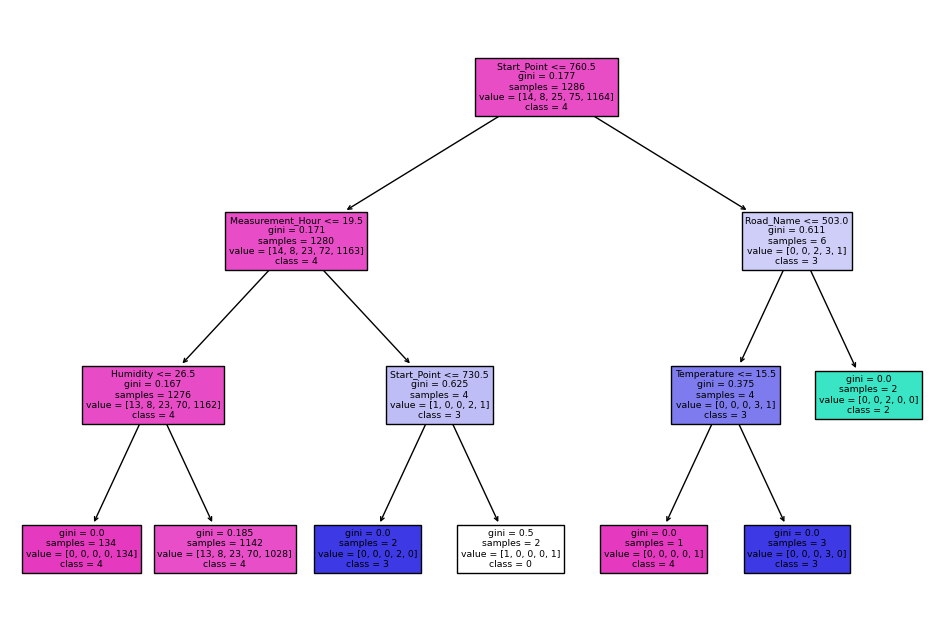

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Define the features (X) and target (y)
X = data.drop('Pollution_Category', axis=1)  # Use all columns except the target as features
y = data['Pollution_Category']  # Target column (already encoded)

# Define and fit the decision tree model
clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Adjust max_depth as needed
clf.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(
    clf,
    feature_names=X.columns,  # Feature names
    class_names=[str(c) for c in sorted(custom_mapping.values())],  # Encoded class names
    filled=True
)
plt.show()




의사결정 트리의 최고 장점은 상대적으로 타 모델들에 비해 단순하기에 이해하기 쉽고 위와 같이 시각화도 쉽게 가능하다는 점이다.
높은 정확도가 나왔지만, Root node의 split 기준이 Start_Point를 760.5 기준으로 나눴는데, 이에 대한 의미의 가치에 대한 의구심이 든다.
원래 숫자형이 아니였던 데이터이기에 예를 들어 "서울-수원-제주-부산"을 "0-1-2-3"으로 인코딩해서 활용했다면 서울이랑 제주 차이가 2이고 부산과의 차이는 3인데
이 숫자들의 사실 아무 의미를 지니지 않기 떄문이다. 또 아쉬운 점은 제일 좌측에 Humidity를 26.5 기준으로 split을 한 node를 살펴보면
결과론적 leaf node들은 둘다 Class 4 매우좋음이다. 이러한 Redundant한 노드들은 불필요하지 않았나라는 아쉬움이 든다.

이번 과제를 통해 수업시간에 학습한 이론적인 개념들을 구현하며 실무, 현실세계 데이터에 대해 고려해야할 점, 난관들을 배울 수 있었으며
다음에 더 큰 데이터나 더 복잡한 모델을 구현 할 수 있을 것이란 자신감이 생겼다.

The greatest advantage of decision trees is their simplicity, making them easier to understand compared to other models. Additionally, as demonstrated above, they are straightforward to visualize. 

While the model achieved high accuracy, there is some skepticism about the meaningfulness of the split criteria at the root node, which divided the data based on a `Start_Point` threshold of 760.5. Since this data was originally non-numeric, for instance, if categories like "Seoul-Suwon-Jeju-Busan" were encoded as "0-1-2-3," the numeric differences (e.g., 2 between Seoul and Jeju or 3 between Seoul and Busan) hold no actual significance. 

Another limitation observed is in the leftmost node, which splits on `Humidity` at a threshold of 26.5. Despite the split, the resulting leaf nodes both belong to Class 4, indicating "Very Good." This suggests redundancy, as such nodes may not have been necessary.

Through this assignment, I was able to implement the theoretical concepts learned in class and better understand the practical considerations and challenges when working with real-world data. This experience has given me the confidence to handle larger datasets and implement more complex models in the future.
